<a href="https://colab.research.google.com/github/alexandre-braga/DeepRL-OpenAi-A2C-DDPG/blob/main/%5B219001%5D_A1_StableBaselines3_A2C_on_box2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Analysis of A2C Algorithm on the box2D tasks

**By UFJF**

__Content creators:__ Alexandre Vitor Silva Braga

__Content editors:__ Alexandre Vitor Silva Braga

---
# Objective

In this project, the objective is to analyze the performance of the Deep Q-Learning algorithm A2C on box2D Environments. Then it will be compared to the Deep Q-Learning algorithm DDPG

#Ambient Configuration

In [ ]:
# @title Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet --quiet

     |████████████████████████████████| 170 kB 5.5 MB/s 
     |████████████████████████████████| 1.6 MB 59.5 MB/s 
     |████████████████████████████████| 1.5 MB 47.7 MB/s 
     |████████████████████████████████| 237 kB 62.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 7.0 MB/s 
     |████████████████████████████████| 448 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
# @title Imports
import io
import imageio
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN, A2C, DDPG
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack

import gym
from gym import spaces
from gym.wrappers import Monitor

from ale_py import ALEInterface
ale = ALEInterface()

In [ ]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#Environments

In [ ]:
NUM_ENVS = 10
LEARNING_RATE = 0.001

In [ ]:
# @title Create environments

env_name1 = 'BipedalWalker-v3'
env_name2 = 'Pendulum-v1'
env_name3 = 'LunarLanderContinuous-v2'

env_walker = gym.make(env_name1)
env_pendulum = gym.make(env_name2)
env_lunar = gym.make(env_name3)

In [ ]:
# @title Create Vec environments (parallel)

num_envs = NUM_ENVS

vec_env_walker = make_vec_env(env_name1, n_envs = num_envs)
vec_env_pendulum = make_vec_env(env_name2, n_envs = 5*num_envs + 1)
vec_env_lunar = make_vec_env(env_name3, n_envs = 5*num_envs)

In [ ]:
# @title Create Atari environment

env_qbert = 'ALE/Qbert-v5'

atari_env = make_atari_env(env_qbert,
                     n_envs=num_envs,
                     seed=0
                    )

# Frame-stacking with 4 frames
vec_atari_env = VecFrameStack(atari_env, n_stack=4)

In [ ]:
# @title For evaluating the performance of the agent periodically and logging the results.
log_dir = "/tmp/gym/"
logwalker_dir = "/tmp/gym/walker/"
loglunar_dir = "/tmp/gym/lunar/"

os.makedirs(logwalker_dir, exist_ok=True)
os.makedirs(loglunar_dir, exist_ok=True)

env_walker = stable_baselines3.common.monitor.Monitor(env_walker, logwalker_dir )
walkercallback = EvalCallback(env_walker, log_path = logwalker_dir, deterministic=True)

env_lunar = stable_baselines3.common.monitor.Monitor(env_lunar, loglunar_dir )
lunarcallback = EvalCallback(env_lunar, log_path = loglunar_dir, deterministic=True) 

#Q Learn Pendulum Implementation

In [ ]:
import tqdm
import math

In [ ]:
discrete_st = [20, 20, 20]
size_ac = 5
discrete_ac = [size_ac]
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1
learning_rate, min_learning_rate = 0.0, 0.3
discount_factor = 0.95
dec = 15
qtable = np.zeros(discrete_st + discrete_ac)

In [ ]:
# Observation space
env_pendulum.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

In [ ]:
lower_bounds_state = [-1.0, -1.0, -8.0] #env_pendulum.observation_space.low
upper_bounds_state = [1.0, 1.0, 8.0] #env_pendulum.observation_space.high

lower_bounds_state, upper_bounds_state

([-1.0, -1.0, -8.0], [1.0, 1.0, 8.0])

In [ ]:
# Action space
env_pendulum.action_space

Box([-2.], [2.], (1,), float32)

In [ ]:
lower_bounds_action = [-2.0] #env_pendulum.action_space.low
upper_bounds_action = [2.0] #env_pendulum.action_space.high

lower_bounds_action, upper_bounds_action

([-2.0], [2.0])

In [ ]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return [np.random.randint(size_ac)]
    else:
        return [np.argmax(qtable[state])]

# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower_bounds_state[i])) / (upper_bounds_state[i] - lower_bounds_state[i])
        new_state = int(round((discrete_st[i] - 1) * stepsize))
        new_state = min(discrete_st[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)

# ---------------------------------------------------------------------#
def discrete_action(action):
    """
        Recebe ações (action space) e o discretiza
    """
    d = list()

    for i in range(len(action)):
        stepsize = (action[i] + abs(lower_bounds_action[i])) / (upper_bounds_action[i] - lower_bounds_action[i])
        new_action = int(round((discrete_ac[i] - 1) * stepsize))
        new_action = min(discrete_ac[i] - 1, max(0, new_action))
        d.append(new_action)

    return tuple(d)

# ---------------------------------------------------------------------#
def continuous_action(idx):
    """
        
    """
    d = list()

    for i in range(len(idx)):
        stepsize = idx[i] / (discrete_ac[i] - 1)
        new_action = lower_bounds_action[i] + stepsize * (upper_bounds_action[i] - lower_bounds_action[i])
        d.append(new_action)

    return tuple(d)

# ---------------------------------------------------------------------#
def get_epsilon(ep):
    '''
      Reduz Epsilon para diminuir a ganância do algoritmo a medida que aumenta os episódios
      Mas, existe minimum_value irredutível, para garantir aleatoriedade
      https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    '''

    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))

# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    '''
      Reduz Alpha (learn rate) para diminuir a ganância do algoritmo a medida que aumenta os episódios
      Mas, existe minimum_value irredutível, para garantir aleatoriedade
      https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    '''

    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))

# ---------------------------------------------------------------------#
def update_qtable(state, action, reward, new_state):
    # atualiza a qtable do QLearning pela formula
    qtable[state][action] += learning_rate * (reward + discount_factor * np.max(qtable[new_state]) - qtable[state][action])

In [ ]:
test = discrete_action([1.9])
print(test)

for x in np.linspace(-2, 2, 10):
    print(x, continuous_action(discrete_action([x])))

(4,)
-2.0 (-2.0,)
-1.5555555555555556 (-2.0,)
-1.1111111111111112 (-1.0,)
-0.6666666666666667 (-1.0,)
-0.22222222222222232 (0.0,)
0.22222222222222232 (0.0,)
0.6666666666666665 (1.0,)
1.1111111111111107 (1.0,)
1.5555555555555554 (2.0,)
2.0 (2.0,)


In [ ]:
# usado para plotar o gráfico de aprendizado
total_rewards = []

for ep in tqdm.tqdm(range(num_eps)):
    current_state = discrete_state(env_pendulum.reset())

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    rewards = []

    while not done:
        #action = choose_action(current_state)
        discrete_action = choose_action(current_state)
        action = continuous_action(discrete_action)
        observation, reward, done, _ = env_pendulum.step(action)
        new_state = discrete_state(observation)
        update_qtable(current_state, discrete_action, reward, new_state)
        current_state = new_state
        rewards.append(reward)
        
    env_pendulum.close()
    total_rewards.append(sum(rewards))

100%|██████████| 3000/3000 [01:45<00:00, 28.36it/s]


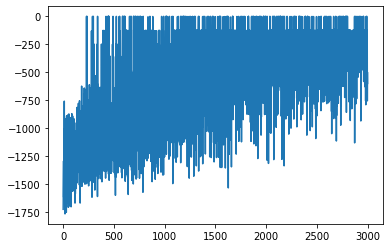

In [ ]:
plt.plot(total_rewards)

#RL Agents Implementation

In [ ]:
# @title Create A2C models

learning_rate = LEARNING_RATE

modelA2C_Walker = A2C('MlpPolicy',
                      vec_env_walker,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )
modelA2C_Lunar = A2C('MlpPolicy',
                      vec_env_lunar,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )

#Possível comparar com Q-Learn
modelA2C_Pendulum = A2C('MlpPolicy',
                      env_pendulum,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )

#Atari tests
modelA2C_Atari = A2C('CnnPolicy',
                      vec_atari_env,
                      verbose = 1,
                     )

Using cpu device
Using cpu device
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# @title Create DDPG models

learning_rate = LEARNING_RATE

modelDDPG_Walker = DDPG('MlpPolicy',
                      env_walker,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )
modelDDPG_Lunar = DDPG('MlpPolicy',
                      env_lunar,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )
#Possível comparar com Q-Learn
modelDDPG_Pendulum = DDPG('MlpPolicy',
                      env_pendulum,
                      learning_rate = learning_rate,
                      verbose = 1,
                     )

Using cpu device
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


O Environment Lunar fornece um espaço Discrete, mesmo sendo considerado Box2D

#Pendulum


In [ ]:
# @title Final Render A2C - 50 Environments

env = wrap_env(gym.make(env_name2))
observation = env.reset()
while True:
  env.render()
  action, _states = modelA2C_Pendulum.predict(observation)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

#Bipedal Walker


In [ ]:
# @title Test Demo

test_env = wrap_env(gym.make(env_name1))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = modelA2C_Walker.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

-92.00428668102592


###A2C

In [ ]:
# @title Training A2C

modelA2C_Walker.learn(total_timesteps=500000, log_interval=10, callback=walkercallback)

Streaming output truncated to the last 5000 lines.
| time/                 |          |
|    fps                | 1485     |
|    iterations         | 7240     |
|    time_elapsed       | 243      |
|    total_timesteps    | 362000   |
| train/                |          |
|    entropy_loss       | -4.07    |
|    explained_variance | 0.748    |
|    learning_rate      | 0.001    |
|    n_updates          | 7239     |
|    policy_loss        | 0.474    |
|    std                | 0.672    |
|    value_loss         | 1.54     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 444      |
|    ep_rew_mean        | -59.2    |
| time/                 |          |
|    fps                | 1485     |
|    iterations         | 7250     |
|    time_elapsed       | 244      |
|    total_timesteps    | 362500   |
| train/                |          |
|    entropy_loss       | -4.07    |
|    explained_variance 

In [ ]:
# @title Final Render A2C - 10 Environments

env = wrap_env(gym.make(env_name1))
observation = env.reset()
while True:
  env.render()
  action, _states = modelA2C_Walker.predict(observation)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

Text(0, 0.5, 'Episode Rewards')

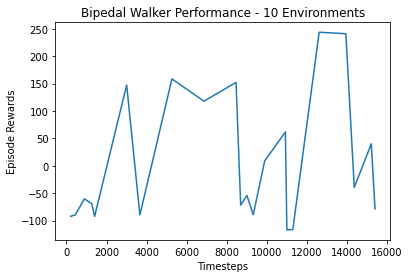

In [ ]:
# @title Walker Performance analysis A2C

x, y = ts2xy(load_results(logwalker_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title('Bipedal Walker Performance - 10 Environments')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

###DDPG

In [ ]:
# @title Training DDPG

modelDDPG_Walker.learn(total_timesteps=50000, log_interval=10, callback=walkercallback)

Eval num_timesteps=1339, episode_reward=-134.68 +/- 1.21
Episode length: 1600.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.6e+03  |
|    mean_reward     | -135     |
| time/              |          |
|    total_timesteps | 1339     |
| train/             |          |
|    actor_loss      | -87.9    |
|    critic_loss     | 4.46     |
|    learning_rate   | 0.001    |
|    n_updates       | 37391    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 857      |
|    ep_rew_mean     | -119     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 49       |
|    time_elapsed    | 196      |
|    total_timesteps | 9799     |
| train/             |          |
|    actor_loss      | -106     |
|    critic_loss     | 6.32     |
|    learning_rate   | 0.001    |
|    n_updates       | 45483    |
--------------------------

In [ ]:
# @title Final Render DDPG

env = wrap_env(gym.make(env_name1))
observation = env.reset()
while True:
  env.render()
  action, _states = modelDDPG_Walker.predict(observation)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

Text(0, 0.5, 'Episode Rewards')

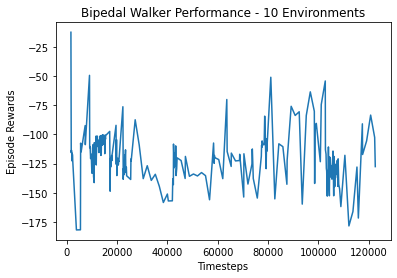

In [ ]:
# @title Walker Performance analysis DDPG

x, y = ts2xy(load_results(logwalker_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title('Bipedal Walker Performance - DDPG')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

#Lunar Lander Discrete

In [ ]:
# @title Teste Demo
test_env = wrap_env(gym.make(env_name3))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = modelA2C_Lunar.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

-64.38676027229954


In [ ]:
# @title Training A2C

modelA2C_Lunar.learn(total_timesteps=500000, log_interval=10, callback=lunarcallback)

------------------------------------
| time/                 |          |
|    fps                | 1002     |
|    iterations         | 10       |
|    time_elapsed       | 2        |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -1.23    |
|    explained_variance | 0.0201   |
|    learning_rate      | 0.0007   |
|    n_updates          | 9        |
|    policy_loss        | -1.47    |
|    value_loss         | 20.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 83.4     |
|    ep_rew_mean        | -180     |
| time/                 |          |
|    fps                | 1322     |
|    iterations         | 20       |
|    time_elapsed       | 3        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -0.963   |
|    explained_variance | 0.00024  |
|    learning_rate      | 0.0007   |
|

In [ ]:
# @title Final Render A2C - 50 Environments

env = wrap_env(gym.make(env_name3))
observation = env.reset()
total_reward = 0

while True:
  env.render()
  action, _states = modelA2C_Lunar.predict(observation)
  observation, reward, done, info = env.step(action)
  total_reward += reward
  if done:
    break;
    
print(total_reward)
env.close()
show_video()

289.2597587753105


Text(0, 0.5, 'Episode Rewards')

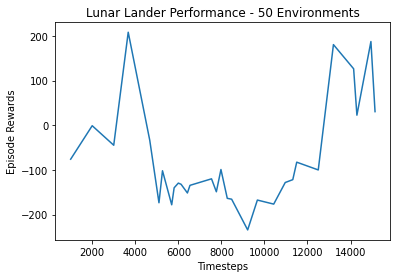

In [ ]:
# @title Performance analysis A2C

x, y = ts2xy(load_results(loglunar_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title('Lunar Lander Performance - 50 Environments')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

###DDPG

Unfortunately DDPG doesn't work with Discrete Environments

#Lunar Lander Continuous

In [ ]:
# @title Teste Demo
test_env = wrap_env(gym.make(env_name3))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = modelA2C_Lunar.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

-147.95668614237542


###A2C

In [ ]:
# @title Training A2C

modelA2C_Lunar.learn(total_timesteps=500000, log_interval=10, callback=lunarcallback)

------------------------------------
| time/                 |          |
|    fps                | 1452     |
|    iterations         | 10       |
|    time_elapsed       | 1        |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | 0.238    |
|    learning_rate      | 0.001    |
|    n_updates          | 9        |
|    policy_loss        | 1.31     |
|    std                | 1.02     |
|    value_loss         | 26.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 85.7     |
|    ep_rew_mean        | -242     |
| time/                 |          |
|    fps                | 1142     |
|    iterations         | 20       |
|    time_elapsed       | 4        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | 0.0749   |
|

In [ ]:
# @title Lunar Final Render A2C - 50 environments

env = wrap_env(gym.make(env_name3))
observation = env.reset()
total_reward = 0

while True:
  env.render()
  action, _states = modelA2C_Lunar.predict(observation)
  observation, reward, done, info = env.step(action)
  total_reward += reward
  if done:
    break;
    
print(total_reward)
env.close()
show_video()

-243.43729974695395


Text(0, 0.5, 'Episode Rewards')

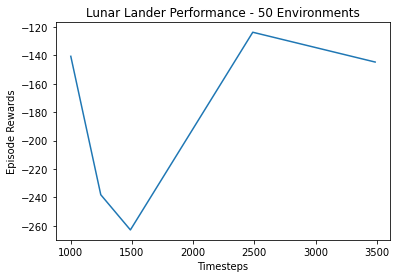

In [ ]:
# @title Performance analysis A2C

x, y = ts2xy(load_results(loglunar_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title('Lunar Lander Performance - 50 Environments')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

###DDPG

In [ ]:
# @title Training DDPG

modelDDPG_Lunar.learn(total_timesteps=50000, log_interval=10, callback=lunarcallback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.8     |
|    ep_rew_mean     | -382     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 75       |
|    time_elapsed    | 13       |
|    total_timesteps | 988      |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 38.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 818      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | -297     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 61       |
|    time_elapsed    | 37       |
|    total_timesteps | 2342     |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 23.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 2220     |
--------------

In [ ]:
# @title Lunar Final Render DDPG

env = wrap_env(gym.make(env_name3))
observation = env.reset()
total_reward = 0

while True:
  env.render()
  action, _states = modelDDPG_Lunar.predict(observation)
  observation, reward, done, info = env.step(action)
  total_reward += reward
  if done:
    break;
    
print(total_reward)
env.close()
show_video()

-51.1682286704403


Text(0, 0.5, 'Episode Rewards')

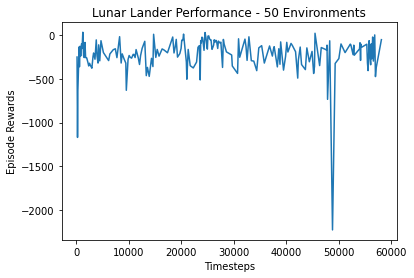

In [ ]:
# @title Performance analysis DDPG

x, y = ts2xy(load_results(loglunar_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title('Lunar Lander Performance - 50 Environments')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

#Atari

In [ ]:
# @title Training

modelA2C_Atari.learn(total_timesteps=60000, log_interval=1000)

In [ ]:
# @title Final Render

images = []
obs = modelA2C_Atari.env.reset()
img = modelA2C_Atari.env.render(mode='rgb_array')
for i in range(1000):
    images.append(img)
    action, _ = modelA2C_Atari.predict(obs)
    obs, _, _ ,_ = modelA2C_Atari.env.step(action)
    img = modelA2C_Atari.env.render(mode='rgb_array')

imageio.mimsave('%s.gif' %env_qbert, [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=30)